# Improving predictive models using non-spherical Gaussian priors
Based on the CNN abstract of [Nunez-Elizalde, Huth, & Gallant](https://www2.securecms.com/CCNeuro/docs-0/5928d71e68ed3f844e8a256f.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
%matplotlib inline

First, let's generate some data with 100 ($N$) samples and 750 ($K$) features. We'll generate the true parameters ($\beta$), for which we'll calculate the covariance matrix ($C$). 

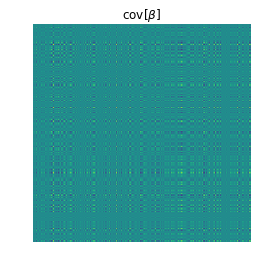

In [2]:
N, K = 100, 750
X = np.random.normal(0, 1, (N, K))
betas = np.random.normal(0, 1, size=(K, 1))
C = np.dot(betas, betas.T)

plt.imshow(C)
plt.axis('off')
plt.title(r'$\mathrm{cov}[\beta]$')
plt.show() 

betas_noisy = betas + np.random.normal(0, 1, (K, 1))
y = X.dot(betas_noisy)

### Standard linear regression (no regularization)

In [3]:
folds = KFold(n_splits=10)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    pipe.fit(X[train_idx], y[train_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])
    
print(scores, end='\n\n')
print("R: %3f. (%.3f)" % (scores.mean(), scores.std()))

[-0.16506543 -0.63245651  0.16840465 -0.37376276  0.01806963  0.03825817
 -0.0855831   0.288809   -0.60611772  0.13488697]

R: -0.121456. (0.304)


### Ridge

In [4]:
folds = KFold(n_splits=10)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RidgeCV())
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R: %3f. (%.3f)" % (scores.mean(), scores.std()))

[-0.14527732 -0.65363145  0.15264436 -0.5162051   0.05021092  0.02806897
 -0.11735493  0.27648749 -0.47586683  0.13369894]

R: -0.126722. (0.303)


### Tikhonov
The traditional solution for Tikhonov regression, for any design matrix $X$ and reponse vector $y$, is usually written as follows:

\begin{align}
\hat{\beta} = (X^{T}X + \lambda C^{T}C)^{-1}X^{T}y
\end{align}

in which $C$ represents the penalty matrix and $\lambda$ the regularization parameter. In this formulation, the prior on the model is that $\beta$ is distributed with zero mean and $(\lambda C^{T}C)^{-1}$ covariance. Alternatively, the estimation of the parameters ($\beta$) can be written as:

\begin{align}
\hat{\beta} = C^{-1}(A^{T}A + \lambda I)^{-1}X^{T}y
\end{align}

with $A$ defined as:

\begin{align}
A = XC^{-1}
\end{align}

Let's define a scikit-learn style class for generic Tikhonov regression:

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin

class Tikhonov(BaseEstimator, RegressorMixin):
    
    def __init__(self, C, lambd=1.):
        self.C = C
        self.lambd = lambd
        
    def fit(self, X, y, sample_weight=None):
        C = self.C
        var_beta = np.linalg.inv(C.T.dot(C))
        self.coef_ = np.linalg.inv(X.T.dot(X) + self.lambd * var_beta).dot(X.T).dot(y)
        return self
    
    def predict(self, X, y=None):
        
        return X.dot(self.coef_)

Now, let's run our (cross-validated) Tikhonov regression:

In [9]:
from sklearn.model_selection import GridSearchCV

folds = KFold(n_splits=10)
lambd = 100

gs = GridSearchCV(estimator=Tikhonov(C=C), param_grid=dict(lambd=[0.1, 1, 10]))

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gs)
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in tqdm_notebook(enumerate(folds.split(X, y))):

    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R: %3f. (%.3f)" % (scores.mean(), scores.std()))


[ 0.64665146  0.13655131  0.11923388  0.29733729  0.60814531  0.57499274
 -0.32242421  0.70671368  0.3417876   0.6029125 ]

R: 0.371190. (0.308)


For some reason, I don't get the same output when I use the alternative ("fast") solution for the $\beta$ parameters (i.e. the one using $A = XC^{-1}$):

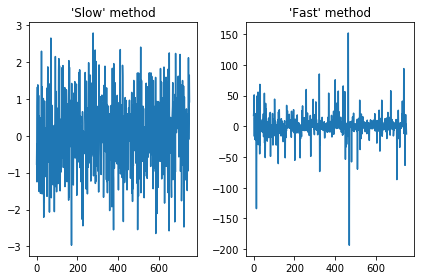

In [7]:
betas_slow = np.linalg.inv(X.T.dot(X) + lambd * np.linalg.inv(C.T.dot(C))).dot(X.T).dot(y)

C_inv = np.linalg.inv(C)
A = X.dot(C_inv)
I = np.eye(X.shape[1])
betas_fast = C_inv.dot(np.linalg.inv(A.T.dot(A) + lambd * I)).dot(A.T).dot(y)

plt.subplot(1, 2, 1)
plt.plot(betas_slow)
plt.title("'Slow' method")
plt.subplot(1, 2, 2)
plt.plot(betas_fast)
plt.title("'Fast' method")
plt.tight_layout()

I do, however, get the same output as the 'slow' method if I don't use the inverse, but the "matrix square root" (function: `sqrtm` from the `scipy.linalg` module) of $C$\*:

\begin{align}
\hat{\beta} = C^{1/2}(A^{T}A + \lambda I)^{-1}X^{T}y
\end{align}

with $A$ defined as:

\begin{align}
A = XC^{1/2}
\end{align}

This method, however, is *much* slower than the traditional implementation.

---
\* Based on the [Github gist](https://gist.github.com/kingjr/926005eb0fba258c4ff380684cb0962b) by Jean-Rémi King.

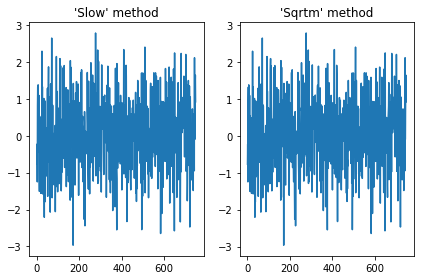

In [8]:
from scipy.linalg import sqrtm

C_sqrtm = np.real(sqrtm(C))
An = X.dot(C_sqrtm)
betas_sqrtm = C_sqrtm.dot(np.linalg.inv(An.T.dot(An) + lambd * I)).dot(An.T).dot(y)

plt.subplot(1, 2, 1)
plt.plot(betas_slow)
plt.title("'Slow' method")
plt.subplot(1, 2, 2)
plt.plot(betas_sqrtm)
plt.title("'Sqrtm' method")
plt.tight_layout()